# 🧵 Fabric Defect Detection with CNN
This notebook implements a fabric defect classification model with bounding boxes and data augmentation.

In [7]:

import os, shutil
import cv2
import numpy as np
from glob import glob
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models


In [8]:

def augment_image(image):
    augmentations = []
    augmentations.append(cv2.flip(image, 1))
    augmentations.append(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE))
    augmentations.append(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))
    alpha = np.random.uniform(0.8, 1.2)
    beta = np.random.randint(-20, 20)
    bright_contrast = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    augmentations.append(bright_contrast)
    return augmentations

def augment_dataset(img_dir, lbl_dir):
    img_paths = sorted(glob(os.path.join(img_dir, '*')))
    for path in tqdm(img_paths):
        ext = path.split('.')[-1].lower()
        if ext not in ['jpg', 'jpeg', 'png']: continue
        base = Path(path).stem
        img = cv2.imread(path)
        label_file = os.path.join(lbl_dir, base + '.txt')
        if not os.path.exists(label_file): continue
        augmenteds = augment_image(img)
        for i, aug in enumerate(augmenteds):
            new_name = f"{base}_aug{i}.jpg"
            cv2.imwrite(os.path.join(img_dir, new_name), aug)
            shutil.copy(label_file, os.path.join(lbl_dir, f"{base}_aug{i}.txt"))


In [9]:

CLASSES = ['hole', 'knot', 'stain']
NUM_CLASSES = len(CLASSES)

class FabricDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]
        base = Path(fname).stem
        img_path = os.path.join(self.image_dir, fname)
        lbl_path = os.path.join(self.label_dir, base + '.txt')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        boxes, labels = [], []
        if os.path.exists(lbl_path):
            with open(lbl_path, 'r') as f:
                for line in f.readlines():
                    cid, xc, yc, bw, bh = map(float, line.strip().split())
                    labels.append(int(cid))
                    x1 = (xc - bw / 2) * w
                    y1 = (yc - bh / 2) * h
                    x2 = (xc + bw / 2) * w
                    y2 = (yc + bh / 2) * h
                    boxes.append([x1, y1, x2, y2])
        boxes = torch.tensor(boxes, dtype=torch.float32)
        label_tensor = torch.tensor(labels, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, boxes, label_tensor, fname

def custom_collate_fn(batch):
    images, boxes, labels, filenames = [], [], [], []
    for img, box, label, fname in batch:
        images.append(img)
        boxes.append(box)
        labels.append(label)
        filenames.append(fname)
    images = torch.stack(images, dim=0)
    return images, boxes, labels, filenames


In [10]:

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(
        degrees=25,
        translate=(0.1, 0.1),
        scale=(0.85, 1.15),
        shear=10,
        interpolation=transforms.InterpolationMode.BILINEAR
    ),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.15), ratio=(0.3, 3.3), value='random')
])


train_data = FabricDataset(
    image_dir="fabric_dataset/images/train",
    label_dir="fabric_dataset/labels/train",
    transform=transform
)

train_loader = DataLoader(
    train_data,
    batch_size=4,
    shuffle=True,
    collate_fn=custom_collate_fn
)


In [11]:

from torchvision.models import resnet18, ResNet18_Weights

class DefectClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DefectClassifier, self).__init__()
        base = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.feature = nn.Sequential(*list(base.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Linear(base.fc.in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DefectClassifier(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, _, labels_list, _ in train_loader:
        imgs = imgs.to(device)
        labels = torch.tensor([l[0] for l in labels_list], dtype=torch.long).to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {acc:.2f}%")


Epoch 1/50, Loss: 1.0944, Accuracy: 22.22%
Epoch 2/50, Loss: 1.0309, Accuracy: 55.56%
Epoch 3/50, Loss: 0.9636, Accuracy: 62.96%
Epoch 4/50, Loss: 0.8651, Accuracy: 70.37%
Epoch 5/50, Loss: 0.8334, Accuracy: 66.67%
Epoch 6/50, Loss: 0.6804, Accuracy: 77.78%
Epoch 7/50, Loss: 0.6895, Accuracy: 70.37%
Epoch 8/50, Loss: 0.7286, Accuracy: 70.37%
Epoch 9/50, Loss: 0.5487, Accuracy: 81.48%
Epoch 10/50, Loss: 0.5048, Accuracy: 88.89%
Epoch 11/50, Loss: 0.3570, Accuracy: 92.59%
Epoch 12/50, Loss: 0.3346, Accuracy: 92.59%
Epoch 13/50, Loss: 0.4203, Accuracy: 92.59%
Epoch 14/50, Loss: 0.4867, Accuracy: 85.19%
Epoch 15/50, Loss: 0.3570, Accuracy: 85.19%
Epoch 16/50, Loss: 0.3811, Accuracy: 88.89%
Epoch 17/50, Loss: 0.4036, Accuracy: 85.19%
Epoch 18/50, Loss: 0.3957, Accuracy: 85.19%
Epoch 19/50, Loss: 0.3020, Accuracy: 88.89%
Epoch 20/50, Loss: 0.4041, Accuracy: 81.48%
Epoch 21/50, Loss: 0.3289, Accuracy: 85.19%
Epoch 22/50, Loss: 0.2978, Accuracy: 88.89%
Epoch 23/50, Loss: 0.4969, Accuracy: 85.1

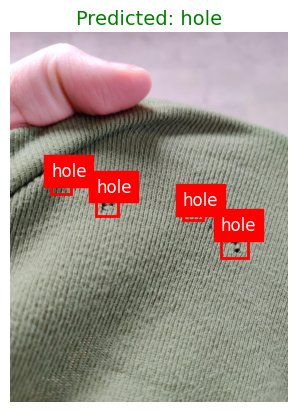

In [18]:

def draw_box(img_path, label_path, predicted_class=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                cid, xc, yc, bw, bh = map(float, line.strip().split())
                x1 = (xc - bw/2) * w
                y1 = (yc - bh/2) * h
                rect = patches.Rectangle((x1, y1), bw*w, bh*h, linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                label = CLASSES[int(cid)]
                ax.text(x1, y1-5, label, color='white', backgroundcolor='red', fontsize=12)
    if predicted_class:
        ax.set_title(f"Predicted: {predicted_class}", fontsize=14, color='green')
    plt.axis('off')
    plt.show()

def predict_image(image_path):
    model.eval()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        return CLASSES[predicted.item()]

test_img = "fabric_dataset/images/train/10_hole.jpg"
test_lbl = "fabric_dataset/labels/train/10_hole.txt"
pred = predict_image(test_img)
draw_box(test_img, test_lbl, predicted_class=pred)
